In [14]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

from idrf import IDRF #Deconvolution routine

In [46]:
from obspy.clients.fdsn.client import Client

client = Client('IRIS')

network = 'II'
station = 'NRIL'

inv = client.get_stations(network=network, station=station,level='response')

sta = inv[0][0]
sta

Station NRIL (Norilsk, Russia)
	Station Code: NRIL
	Channel Count: 24/24 (Selected/Total)
	1992-12-15T00:00:00.000000Z - 1999-10-13T23:59:59.000000Z
	Access: open 
	Latitude: 69.50, Longitude: 88.44, Elevation: 92.0 m
	Available Channels:
		NRIL.00.BHZ, NRIL.00.BHN, NRIL.00.BHE, NRIL.00.BLZ, NRIL.00.BLN, 
		NRIL.00.BLE, NRIL.00.EHZ, NRIL.00.EHN, NRIL.00.EHE, NRIL.00.ELZ, 
		NRIL.00.ELN, NRIL.00.ELE, NRIL.00.LHZ, NRIL.00.LHN, NRIL.00.LHE, 
		NRIL.00.LLZ, NRIL.00.LLN, NRIL.00.LLE, NRIL.00.VHZ, NRIL.00.VHN, 
		NRIL.00.VHE, NRIL.00.VMZ, NRIL.00.VMN, NRIL.00.VME

In [15]:
import wget

!rm *.ndk

url = 'http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/jan76_dec17.ndk'
wget.download( url )


'jan76_dec17.ndk'

In [16]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = obspy.read_events('jan76_dec17.ndk')

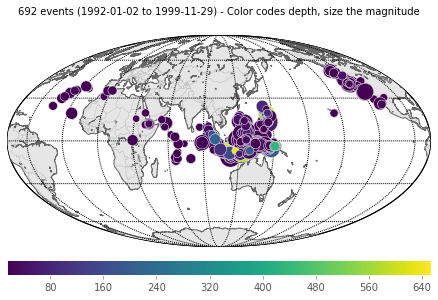

In [20]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = cat.filter("time > 1992-01-01T00:00",
                  "time < 1999-12-01T00:00").filter('magnitude >= 5.5')

cat2 = obspy.core.event.Catalog()

for evt in cat:
    elat=evt.origins[0].latitude
    elon=evt.origins[0].longitude
    slat=sta.latitude
    slon=sta.longitude
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg=delm/1000/111.11
    if deldeg > 55 and deldeg < 85:
        cat2.append(evt)
        
_ = cat2.plot()
    

In [24]:
from scipy.signal import tukey
from numpy import arange, linspace, zeros
from numpy.random import randn
from numpy import argmax, nan
import warnings
warnings.filterwarnings('ignore')

model = TauPyModel(model="iasp91")

#tries = linspace(0.5, 0.90, 5)
pctage=0.80

#tshifts = [-6, -3, 0, 3, 6]
tshifts = [0]

rbin    = zeros(len(tshifts)*len(cat2)*700).reshape(len(tshifts),len(cat2),700) * nan
rbin_s  = rbin.copy()
mbin1   = zeros(len(tshifts)*len(cat2)).reshape(len(tshifts),len(cat2)) * nan
mbin1_s = mbin1.copy()
mbin2   = mbin1.copy()
mbin2_s = mbin1.copy()

for ievt in range(len(cat2)):
    print('Working on %5d of %5d' % (ievt+1,len(cat2)))

    strike=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
    dip=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
    rake=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake

    quake_depth_in_km=cat2[ievt].preferred_origin().depth/1000.0
    
    etime = cat2[ievt].preferred_origin().time

    slat=sta.latitude
    slon=sta.longitude
    elat=cat2[ievt].preferred_origin().latitude
    elon=cat2[ievt].preferred_origin().longitude

    client_syn = Client()
    
    t1=etime
    t2=etime+3600./2.

    for wvfrm_type in ['data','synthetic']:
    
        if wvfrm_type == 'synthetic':
            tmpstr = '%8.1f %8.1f %6.1f %8.1f %8.1f %8.2f %8.2f %8.2f ' % (elat, elon, quake_depth_in_km, slat, slon, strike, dip, rake)
            print(tmpstr)
            stis = client_syn.get_waveforms(model="iasp91_2s",
                                              sourcelatitude=elat,
                                              sourcelongitude=elon,
                                              sourcedepthinmeters=1000.*quake_depth_in_km,
                                              receiverlatitude=slat, receiverlongitude=slon,
                                              sourcedoublecouple=[strike,dip,rake],
                                              origintime=etime,
                                              units='velocity', starttime=t1, endtime=t2)
        else:
            #
            try:
                stis=client.get_waveforms(network,station,'00','LH?',t1,t2,attach_response=True)
                pre_filt = (0.005, 0.01, 5.0, 10.0)
                stis.remove_response(output='VEL', pre_filt=pre_filt)
            except:
                print('  get_waveforms failed.')
                break


            #

        print(stis)

        #print('...strike, dip, rake, elat, elon, quake_depth_in_km = %3d %3d %3d %5d %5d %5d %5d' % (strike, dip, rake, elat, elon, slat, quake_depth_in_km))


        delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
        deldeg=delm/1000/111.11

        arrivals = model.get_travel_times(source_depth_in_km=quake_depth_in_km, distance_in_degree=deldeg,phase_list=['S'])

        try:
            stis.rotate('->ZNE',inventory=inv)
            #stis.rotate('NE->RT', back_azimuth = baz)
            stis.rotate('ZNE->LQT', inclination=arrivals[0].incident_angle, back_azimuth = baz)
            stis.detrend()
        except ValueError as e:
            print('Error: %s' % e)
            break

        stis.filter('bandpass', freqmin = 1./100., freqmax = 1./8., zerophase=True)
        #stis.filter('highpass', freq=1./20., zerophase=True)
        stis.resample(5)
        stis.differentiate()

        t1=etime+arrivals[0].time - 50
        t2=etime+arrivals[0].time + 50

        for ii, tshift in enumerate(tshifts):

            
            stis2=stis.copy().trim(t1+tshift,t2+tshift)
            
            try:
                dt = stis2[0].stats.delta
            except IndexError as e:
                print(e)
                break
                
            try:
                assert 'L' in stis2[0].stats.channel
                assert 'Q' in stis2[1].stats.channel
                #assert 'T' in stis2[2].stats.channel
            except AssertionError as e:
                print(e)
                break
            except IndexError as e:
                print(e)
                break
            
            

            P = stis2[1].copy().data
            D = stis2[0].copy().data

            #Indeces to mask out
            i1 = int(len(P) * (pctage)/2)
            i2 = int(len(P) - i1)
            
            N1=P.copy()[:i1]
            N2=D.copy()[:i1]

            P[:i1]=0.0
            P[i2:]=0.0
            P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))

            smax  = max(abs(P))
            nmax1 = max(abs(N1))
            nmax2 = max(abs(N2))
            #print(i1,i2,imax)
            
            TB = 1.5
            NT = 2

            Poverlap = 0.99
            win_len  = 100

            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
            
            times, RF     = IDRF(P,D,dt)
            _,     RFnorm = IDRF(P,D,dt)
            
            #_, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

            if wvfrm_type == 'synthetic':
                rbin_s[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1_s[ii,ievt] = smax/nmax1
                mbin2_s[ii,ievt] = smax/nmax2
            else:
                rbin[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1[ii,ievt] = smax/nmax1
                mbin2[ii,ievt] = smax/nmax2
        

Working on     1 of   692
  get_waveforms failed.
Working on     2 of   692
  get_waveforms failed.
Working on     3 of   692
  get_waveforms failed.
Working on     4 of   692
  get_waveforms failed.
Working on     5 of   692
  get_waveforms failed.
Working on     6 of   692
  get_waveforms failed.
Working on     7 of   692
  get_waveforms failed.
Working on     8 of   692
  get_waveforms failed.
Working on     9 of   692
  get_waveforms failed.
Working on    10 of   692
  get_waveforms failed.
Working on    11 of   692
  get_waveforms failed.
Working on    12 of   692
  get_waveforms failed.
Working on    13 of   692
  get_waveforms failed.
Working on    14 of   692
  get_waveforms failed.
Working on    15 of   692
  get_waveforms failed.
Working on    16 of   692
  get_waveforms failed.
Working on    17 of   692
  get_waveforms failed.
Working on    18 of   692
  get_waveforms failed.
Working on    19 of   692
  get_waveforms failed.
Working on    20 of   692
  get_waveforms failed.


3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-01-03T04:43:48.700000Z - 1993-01-03T04:45:28.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-01-03T04:43:48.700000Z - 1993-01-03T04:45:28.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-01-03T04:43:48.700000Z - 1993-01-03T04:45:28.600000Z | 10.0 Hz, 1000 samples
Working on    93 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-01-03T17:08:15.000000Z - 1993-01-03T17:38:14.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-01-03T17:08:15.000000Z - 1993-01-03T17:38:14.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-01-03T17:08:15.000000Z - 1993-01-03T17:38:14.000000Z | 1.0 Hz, 1800 samples
    -4.1    129.4   20.3     69.5     88.4   316.00    48.00   134.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-01-03T17:29:21.100000Z - 1993-01-03T17:31:01.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-01-03T17:29:21.100000Z - 1993-01-03T17:31:01.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-01-03T17:29:21.10000

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-03-01T01:39:35.000000Z - 1993-03-01T02:09:35.000000Z | 1.0 Hz, 1801 samples
II.NRIL.00.LHN | 1993-03-01T01:39:35.000000Z - 1993-03-01T02:09:35.000000Z | 1.0 Hz, 1801 samples
II.NRIL.00.LHZ | 1993-03-01T01:39:35.000000Z - 1993-03-01T02:09:35.000000Z | 1.0 Hz, 1801 samples
    -3.7    138.7   97.5     69.5     88.4   178.00    43.00  -141.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-03-01T02:00:45.700000Z - 1993-03-01T02:02:25.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-03-01T02:00:45.700000Z - 1993-03-01T02:02:25.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-03-01T02:00:45.700000Z - 1993-03-01T02:02:25.600000Z | 10.0 Hz, 1000 samples
Working on   107 of   692
  get_waveforms failed.
Working on   108 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-03-05T08:21:01.000000Z - 1993-03-05T08:51:00.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-03-05T08:21:01.000000Z - 1993-03-05T08:51:00.000000Z | 1.0 Hz, 1800 sampl

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-05-17T02:26:38.800000Z - 1993-05-17T02:28:18.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-05-17T02:26:38.800000Z - 1993-05-17T02:28:18.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-05-17T02:26:38.800000Z - 1993-05-17T02:28:18.700000Z | 10.0 Hz, 1000 samples
Working on   120 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-05-17T23:20:54.000000Z - 1993-05-17T23:50:53.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-05-17T23:20:54.000000Z - 1993-05-17T23:50:53.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-05-17T23:20:54.000000Z - 1993-05-17T23:50:53.000000Z | 1.0 Hz, 1800 samples
    36.7   -118.1   15.0     69.5     88.4   210.00    30.00   -93.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-05-17T23:40:52.000000Z - 1993-05-17T23:42:31.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-05-17T23:40:52.000000Z - 1993-05-17T23:42:31.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-05-17T23:40:52.00000

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-06-12T18:26:47.000000Z - 1993-06-12T18:56:46.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-06-12T18:26:47.000000Z - 1993-06-12T18:56:46.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-06-12T18:26:47.000000Z - 1993-06-12T18:56:46.000000Z | 1.0 Hz, 1800 samples
    -4.3    135.1   15.0     69.5     88.4   263.00    61.00     5.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-06-12T18:48:11.400000Z - 1993-06-12T18:49:51.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-06-12T18:48:11.400000Z - 1993-06-12T18:49:51.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-06-12T18:48:11.400000Z - 1993-06-12T18:49:51.300000Z | 10.0 Hz, 1000 samples
Working on   132 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-06-15T13:06:40.000000Z - 1993-06-15T13:36:39.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-06-15T13:06:40.000000Z - 1993-06-15T13:36:39.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-06-15T13:06:40.000000Z - 

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-08-29T09:57:51.000000Z - 1993-08-29T10:27:50.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-08-29T09:57:51.000000Z - 1993-08-29T10:27:50.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-08-29T09:57:51.000000Z - 1993-08-29T10:27:50.000000Z | 1.0 Hz, 1800 samples
    -7.0    129.5  121.0     69.5     88.4   166.00    39.00   139.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-08-29T10:19:05.100000Z - 1993-08-29T10:20:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-08-29T10:19:05.100000Z - 1993-08-29T10:20:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-08-29T10:19:05.100000Z - 1993-08-29T10:20:45.000000Z | 10.0 Hz, 1000 samples
Working on   147 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-09-01T11:48:44.000000Z - 1993-09-01T12:18:43.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-09-01T11:48:44.000000Z - 1993-09-01T12:18:43.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-09-01T11:48:44.000000Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-10-05T05:31:15.000000Z - 1993-10-05T05:32:54.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-10-05T05:31:15.000000Z - 1993-10-05T05:32:54.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-10-05T05:31:15.000000Z - 1993-10-05T05:32:54.900000Z | 10.0 Hz, 1000 samples
Working on   160 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-10-13T02:06:09.000000Z - 1993-10-13T02:36:08.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-10-13T02:06:09.000000Z - 1993-10-13T02:36:08.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-10-13T02:06:09.000000Z - 1993-10-13T02:36:08.000000Z | 1.0 Hz, 1800 samples
    -6.0    146.1   15.0     69.5     88.4   310.00     8.00   110.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-10-13T02:28:21.900000Z - 1993-10-13T02:30:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-10-13T02:28:21.900000Z - 1993-10-13T02:30:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-10-13T02:28:21.90000

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-11-28T10:50:33.000000Z - 1993-11-28T11:20:32.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-11-28T10:50:33.000000Z - 1993-11-28T11:20:32.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-11-28T10:50:33.000000Z - 1993-11-28T11:20:32.000000Z | 1.0 Hz, 1800 samples
    -5.5    110.3  573.2     69.5     88.4   317.00    50.00   -56.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-11-28T11:09:33.400000Z - 1993-11-28T11:11:13.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-11-28T11:09:33.400000Z - 1993-11-28T11:11:13.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-11-28T11:09:33.400000Z - 1993-11-28T11:11:13.300000Z | 10.0 Hz, 1000 samples
Working on   174 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1993-11-29T20:28:48.000000Z - 1993-11-29T20:58:47.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1993-11-29T20:28:48.000000Z - 1993-11-29T20:58:47.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1993-11-29T20:28:48.000000Z - 

  get_waveforms failed.
Working on   200 of   692
  get_waveforms failed.
Working on   201 of   692
  get_waveforms failed.
Working on   202 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-02-23T23:39:56.000000Z - 1994-02-24T00:09:55.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-02-23T23:39:56.000000Z - 1994-02-24T00:09:55.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-02-23T23:39:56.000000Z - 1994-02-24T00:09:55.000000Z | 1.0 Hz, 1800 samples
    18.3    147.2   15.0     69.5     88.4   137.00    25.00    53.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-02-23T23:57:53.000000Z - 1994-02-23T23:59:32.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-02-23T23:57:53.000000Z - 1994-02-23T23:59:32.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1994-02-23T23:57:53.000000Z - 1994-02-23T23:59:32.900000Z | 10.0 Hz, 1000 samples
Working on   203 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-02-28T21:52:55.000000Z - 1994-02-28T22:22:54.000000Z | 1.0 Hz, 1800 sam

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-06-03T21:07:08.000000Z - 1994-06-03T21:37:07.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-06-03T21:07:08.000000Z - 1994-06-03T21:37:07.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-06-03T21:07:08.000000Z - 1994-06-03T21:37:07.000000Z | 1.0 Hz, 1800 samples
   -10.8    113.1   15.0     69.5     88.4   271.00    38.00   -86.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-06-03T21:28:50.500000Z - 1994-06-03T21:30:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-06-03T21:28:50.500000Z - 1994-06-03T21:30:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1994-06-03T21:28:50.500000Z - 1994-06-03T21:30:30.400000Z | 10.0 Hz, 1000 samples
Working on   231 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-06-04T00:58:00.000000Z - 1994-06-04T01:27:59.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-06-04T00:58:00.000000Z - 1994-06-04T01:27:59.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-06-04T00:58:00.000000Z - 

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-07-06T09:13:13.000000Z - 1994-07-06T09:43:12.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-07-06T09:13:13.000000Z - 1994-07-06T09:43:12.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-07-06T09:13:13.000000Z - 1994-07-06T09:43:12.000000Z | 1.0 Hz, 1800 samples
     6.0    126.1  148.0     69.5     88.4   253.00    41.00  -173.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-07-06T09:31:54.100000Z - 1994-07-06T09:33:34.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-07-06T09:31:54.100000Z - 1994-07-06T09:33:34.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1994-07-06T09:31:54.100000Z - 1994-07-06T09:33:34.000000Z | 10.0 Hz, 1000 samples
Working on   246 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-07-13T11:45:31.000000Z - 1994-07-13T12:15:30.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-07-13T11:45:31.000000Z - 1994-07-13T12:15:30.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-07-13T11:45:31.000000Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-09-12T12:43:19.400000Z - 1994-09-12T12:44:59.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-09-12T12:43:19.400000Z - 1994-09-12T12:44:59.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1994-09-12T12:43:19.400000Z - 1994-09-12T12:44:59.300000Z | 10.0 Hz, 1000 samples
Working on   258 of   692
  get_waveforms failed.
Working on   259 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-09-23T07:59:41.000000Z - 1994-09-23T08:29:40.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-09-23T07:59:41.000000Z - 1994-09-23T08:29:40.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-09-23T07:59:41.000000Z - 1994-09-23T08:29:40.000000Z | 1.0 Hz, 1800 samples
    -3.1    149.0   15.0     69.5     88.4    20.00    80.00   178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-09-23T08:21:34.800000Z - 1994-09-23T08:23:14.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-09-23T08:21:34.800000Z - 1994-09-23T08:23:14.700000Z | 10.0 Hz, 1000 s

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-11-14T19:15:40.000000Z - 1994-11-14T19:45:39.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-11-14T19:15:40.000000Z - 1994-11-14T19:45:39.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-11-14T19:15:40.000000Z - 1994-11-14T19:45:39.000000Z | 1.0 Hz, 1800 samples
    13.4    121.3   15.0     69.5     88.4   339.00    70.00  -178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-11-14T19:33:04.700000Z - 1994-11-14T19:34:44.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-11-14T19:33:04.700000Z - 1994-11-14T19:34:44.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1994-11-14T19:33:04.700000Z - 1994-11-14T19:34:44.600000Z | 10.0 Hz, 1000 samples
Working on   274 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1994-11-15T06:25:12.000000Z - 1994-11-15T06:55:11.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1994-11-15T06:25:12.000000Z - 1994-11-15T06:55:11.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1994-11-15T06:25:12.000000Z - 

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1995-02-13T13:06:51.000000Z - 1995-02-13T13:36:50.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1995-02-13T13:06:51.000000Z - 1995-02-13T13:36:50.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1995-02-13T13:06:51.000000Z - 1995-02-13T13:36:50.000000Z | 1.0 Hz, 1800 samples
    -1.3    127.6   35.0     69.5     88.4     5.00    34.00   -96.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-02-13T13:27:19.200000Z - 1995-02-13T13:28:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-02-13T13:27:19.200000Z - 1995-02-13T13:28:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-02-13T13:27:19.200000Z - 1995-02-13T13:28:59.100000Z | 10.0 Hz, 1000 samples
Working on   293 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1995-02-13T15:04:31.000000Z - 1995-02-13T15:34:30.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1995-02-13T15:04:31.000000Z - 1995-02-13T15:34:30.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1995-02-13T15:04:31.000000Z - 

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1995-10-20T19:21:38.000000Z - 1995-10-20T19:51:37.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1995-10-20T19:21:38.000000Z - 1995-10-20T19:51:37.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1995-10-20T19:21:38.000000Z - 1995-10-20T19:51:37.000000Z | 1.0 Hz, 1800 samples
    19.2    145.6  207.2     69.5     88.4   186.00    50.00   148.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-10-20T19:38:40.500000Z - 1995-10-20T19:40:20.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-10-20T19:38:40.500000Z - 1995-10-20T19:40:20.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-10-20T19:38:40.500000Z - 1995-10-20T19:40:20.400000Z | 10.0 Hz, 1000 samples
Working on   367 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1995-10-22T19:54:51.000000Z - 1995-10-22T20:24:50.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1995-10-22T19:54:51.000000Z - 1995-10-22T20:24:50.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1995-10-22T19:54:51.000000Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-11-25T20:22:53.800000Z - 1995-11-25T20:24:33.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-11-25T20:22:53.800000Z - 1995-11-25T20:24:33.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-11-25T20:22:53.800000Z - 1995-11-25T20:24:33.700000Z | 10.0 Hz, 1000 samples
Working on   380 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1995-12-05T06:32:13.000000Z - 1995-12-05T07:02:12.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1995-12-05T06:32:13.000000Z - 1995-12-05T07:02:12.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1995-12-05T06:32:13.000000Z - 1995-12-05T07:02:12.000000Z | 1.0 Hz, 1800 samples
    -9.0    125.1   37.5     69.5     88.4    73.00    69.00    -7.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-12-05T06:53:53.900000Z - 1995-12-05T06:55:33.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-12-05T06:53:53.900000Z - 1995-12-05T06:55:33.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-12-05T06:53:53.90000

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-03-19T15:53:51.000000Z - 1996-03-19T15:55:30.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-03-19T15:53:51.000000Z - 1996-03-19T15:55:30.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-03-19T15:53:51.000000Z - 1996-03-19T15:55:30.900000Z | 10.0 Hz, 1000 samples
Working on   410 of   692
  get_waveforms failed.
Working on   411 of   692
  get_waveforms failed.
Working on   412 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1996-04-02T18:50:44.000000Z - 1996-04-02T19:20:43.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1996-04-02T18:50:44.000000Z - 1996-04-02T19:20:43.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1996-04-02T18:50:44.000000Z - 1996-04-02T19:20:43.000000Z | 1.0 Hz, 1800 samples
     3.1    126.4   15.0     69.5     88.4   351.00    20.00    56.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-04-02T19:10:25.500000Z - 1996-04-02T19:12:05.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-04-02T19:10:25.50000

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-06-11T18:40:48.200000Z - 1996-06-11T18:42:28.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-06-11T18:40:48.200000Z - 1996-06-11T18:42:28.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-06-11T18:40:48.200000Z - 1996-06-11T18:42:28.100000Z | 10.0 Hz, 1000 samples
Working on   427 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1996-06-14T15:04:42.000000Z - 1996-06-14T15:34:41.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1996-06-14T15:04:42.000000Z - 1996-06-14T15:34:41.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1996-06-14T15:04:42.000000Z - 1996-06-14T15:34:41.000000Z | 1.0 Hz, 1800 samples
    13.0    124.9   27.4     69.5     88.4   222.00    51.00  -133.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-06-14T15:22:19.900000Z - 1996-06-14T15:23:59.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-06-14T15:22:19.900000Z - 1996-06-14T15:23:59.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-06-14T15:22:19.90000

     0.1    123.2  133.3     69.5     88.4   289.00    54.00   135.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-08-01T04:28:09.500000Z - 1996-08-01T04:29:49.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-08-01T04:28:09.500000Z - 1996-08-01T04:29:49.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-08-01T04:28:09.500000Z - 1996-08-01T04:29:49.400000Z | 10.0 Hz, 1000 samples
Working on   444 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1996-08-08T23:12:38.000000Z - 1996-08-08T23:13:19.000000Z | 1.0 Hz, 42 samples
II.NRIL.00.LHN | 1996-08-08T23:12:38.000000Z - 1996-08-08T23:13:19.000000Z | 1.0 Hz, 42 samples
II.NRIL.00.LHZ | 1996-08-08T23:12:38.000000Z - 1996-08-08T23:13:19.000000Z | 1.0 Hz, 42 samples
list index out of range
    11.9    126.1   15.0     69.5     88.4   183.00    18.00    99.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-08-08T23:30:36.200000Z - 1996-08-08T23:32:16.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-08-08T23:30:36.200000Z - 1996-0

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-09-16T06:09:25.300000Z - 1996-09-16T06:11:05.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-09-16T06:09:25.300000Z - 1996-09-16T06:11:05.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-09-16T06:09:25.300000Z - 1996-09-16T06:11:05.200000Z | 10.0 Hz, 1000 samples
Working on   458 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1996-09-18T05:29:09.000000Z - 1996-09-18T05:59:08.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1996-09-18T05:29:09.000000Z - 1996-09-18T05:59:08.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1996-09-18T05:29:09.000000Z - 1996-09-18T05:59:08.000000Z | 1.0 Hz, 1800 samples
     9.5    126.6   20.5     69.5     88.4   168.00    28.00    77.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-09-18T05:47:35.800000Z - 1996-09-18T05:49:15.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-09-18T05:47:35.800000Z - 1996-09-18T05:49:15.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-09-18T05:47:35.80000

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1996-10-02T09:48:07.000000Z - 1996-10-02T10:18:06.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1996-10-02T09:48:07.000000Z - 1996-10-02T10:18:06.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1996-10-02T09:48:07.000000Z - 1996-10-02T10:18:06.000000Z | 1.0 Hz, 1800 samples
    11.9    125.8   22.0     69.5     88.4   154.00    25.00    59.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-10-02T10:06:02.400000Z - 1996-10-02T10:07:42.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-10-02T10:06:02.400000Z - 1996-10-02T10:07:42.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-10-02T10:06:02.400000Z - 1996-10-02T10:07:42.300000Z | 10.0 Hz, 1000 samples
Working on   470 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1996-10-04T08:03:14.000000Z - 1996-10-04T08:33:13.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1996-10-04T08:03:14.000000Z - 1996-10-04T08:33:13.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1996-10-04T08:03:14.000000Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-11-03T08:00:04.900000Z - 1996-11-03T08:01:44.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-11-03T08:00:04.900000Z - 1996-11-03T08:01:44.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-11-03T08:00:04.900000Z - 1996-11-03T08:01:44.800000Z | 10.0 Hz, 1000 samples
Working on   483 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1996-11-04T12:53:41.000000Z - 1996-11-04T13:23:40.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1996-11-04T12:53:41.000000Z - 1996-11-04T13:23:40.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1996-11-04T12:53:41.000000Z - 1996-11-04T13:23:40.000000Z | 1.0 Hz, 1800 samples
     9.7    126.7   19.0     69.5     88.4   163.00    29.00    85.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-11-04T13:12:06.300000Z - 1996-11-04T13:13:46.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-11-04T13:12:06.300000Z - 1996-11-04T13:13:46.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-11-04T13:12:06.30000

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-02-15T12:31:46.700000Z - 1997-02-15T12:33:26.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-02-15T12:31:46.700000Z - 1997-02-15T12:33:26.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-02-15T12:31:46.700000Z - 1997-02-15T12:33:26.600000Z | 10.0 Hz, 1000 samples
Working on   507 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1997-03-04T04:40:44.000000Z - 1997-03-04T05:10:43.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1997-03-04T04:40:44.000000Z - 1997-03-04T05:10:43.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1997-03-04T04:40:44.000000Z - 1997-03-04T05:10:43.000000Z | 1.0 Hz, 1800 samples
    -7.6    129.2  128.5     69.5     88.4    82.00    54.00     7.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-03-04T05:02:02.300000Z - 1997-03-04T05:03:42.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-03-04T05:02:02.300000Z - 1997-03-04T05:03:42.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-03-04T05:02:02.30000

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-05-10T19:14:06.700000Z - 1997-05-10T19:15:46.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-05-10T19:14:06.700000Z - 1997-05-10T19:15:46.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-05-10T19:14:06.700000Z - 1997-05-10T19:15:46.600000Z | 10.0 Hz, 1000 samples
Working on   521 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1997-05-12T13:45:26.000000Z - 1997-05-12T14:15:25.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1997-05-12T13:45:26.000000Z - 1997-05-12T14:15:25.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1997-05-12T13:45:26.000000Z - 1997-05-12T14:15:25.000000Z | 1.0 Hz, 1800 samples
    10.1    121.4   28.8     69.5     88.4   276.00    70.00  -171.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-05-12T14:03:29.400000Z - 1997-05-12T14:05:09.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-05-12T14:03:29.400000Z - 1997-05-12T14:05:09.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-05-12T14:03:29.40000

    14.6    144.6   15.0     69.5     88.4   103.00    37.00  -106.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-08-30T03:47:07.900000Z - 1997-08-30T03:48:47.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-08-30T03:47:07.900000Z - 1997-08-30T03:48:47.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-08-30T03:47:07.900000Z - 1997-08-30T03:48:47.800000Z | 10.0 Hz, 1000 samples
Working on   537 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1997-09-04T20:53:06.000000Z - 1997-09-04T21:23:05.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1997-09-04T20:53:06.000000Z - 1997-09-04T21:23:05.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1997-09-04T20:53:06.000000Z - 1997-09-04T21:23:05.000000Z | 1.0 Hz, 1800 samples
    -3.3    151.6  385.8     69.5     88.4   193.00    43.00    12.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-09-04T21:13:55.800000Z - 1997-09-04T21:15:35.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-09-04T21:13:55.800000Z - 1997-09-04T21:15:35.7000

3 Trace(s) in Stream:
II.NRIL.00.LHE | 1997-11-03T19:18:03.000000Z - 1997-11-03T19:48:02.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1997-11-03T19:18:03.000000Z - 1997-11-03T19:48:02.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1997-11-03T19:18:03.000000Z - 1997-11-03T19:48:02.000000Z | 1.0 Hz, 1800 samples
    -6.7    129.1  221.0     69.5     88.4    78.00    37.00    51.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-11-03T19:38:53.500000Z - 1997-11-03T19:40:33.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-11-03T19:38:53.500000Z - 1997-11-03T19:40:33.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-11-03T19:38:53.500000Z - 1997-11-03T19:40:33.400000Z | 10.0 Hz, 1000 samples
Working on   552 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1997-11-05T09:59:19.000000Z - 1997-11-05T10:29:18.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1997-11-05T09:59:19.000000Z - 1997-11-05T10:29:18.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1997-11-05T09:59:19.000000Z - 

  get_waveforms failed.
Working on   577 of   692
  get_waveforms failed.
Working on   578 of   692
1 Trace(s) in Stream:
II.NRIL.00.LHZ | 1998-05-11T04:01:48.000000Z - 1998-05-11T04:31:48.000000Z | 1.0 Hz, 1801 samples
list index out of range
    -3.3    142.7   17.7     69.5     88.4   156.00    20.00   106.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1998-05-11T04:23:23.800000Z - 1998-05-11T04:25:03.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1998-05-11T04:23:23.800000Z - 1998-05-11T04:25:03.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1998-05-11T04:23:23.800000Z - 1998-05-11T04:25:03.700000Z | 10.0 Hz, 1000 samples
Working on   579 of   692
1 Trace(s) in Stream:
II.NRIL.00.LHZ | 1998-05-15T05:58:12.000000Z - 1998-05-15T06:28:12.000000Z | 1.0 Hz, 1801 samples
list index out of range
    14.0    145.0  167.6     69.5     88.4   187.00    43.00    23.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1998-05-15T06:16:20.400000Z - 1998-05-15T06:18:00.300000Z | 10.0 Hz, 1000 samples


3 Trace(s) in Stream:
II.NRIL.00.LHE | 1999-06-21T04:35:49.000000Z - 1999-06-21T05:05:48.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1999-06-21T04:35:49.000000Z - 1999-06-21T05:05:48.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1999-06-21T04:35:49.000000Z - 1999-06-21T05:05:48.000000Z | 1.0 Hz, 1800 samples
     8.1    141.6   15.0     69.5     88.4   137.00    79.00    10.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1999-06-21T04:55:21.700000Z - 1999-06-21T04:57:01.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1999-06-21T04:55:21.700000Z - 1999-06-21T04:57:01.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1999-06-21T04:55:21.700000Z - 1999-06-21T04:57:01.600000Z | 10.0 Hz, 1000 samples
Working on   658 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1999-06-22T00:47:43.000000Z - 1999-06-22T01:17:42.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1999-06-22T00:47:43.000000Z - 1999-06-22T01:17:42.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1999-06-22T00:47:43.000000Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1999-09-13T05:05:18.700000Z - 1999-09-13T05:06:58.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1999-09-13T05:05:18.700000Z - 1999-09-13T05:06:58.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1999-09-13T05:05:18.700000Z - 1999-09-13T05:06:58.600000Z | 10.0 Hz, 1000 samples
Working on   678 of   692
3 Trace(s) in Stream:
II.NRIL.00.LHE | 1999-09-19T03:19:01.000000Z - 1999-09-19T03:49:00.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHN | 1999-09-19T03:19:01.000000Z - 1999-09-19T03:49:00.000000Z | 1.0 Hz, 1800 samples
II.NRIL.00.LHZ | 1999-09-19T03:19:01.000000Z - 1999-09-19T03:49:00.000000Z | 1.0 Hz, 1800 samples
    -3.6    150.9  435.4     69.5     88.4   212.00    39.00    28.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1999-09-19T03:39:41.900000Z - 1999-09-19T03:41:21.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1999-09-19T03:39:41.900000Z - 1999-09-19T03:41:21.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1999-09-19T03:39:41.90000

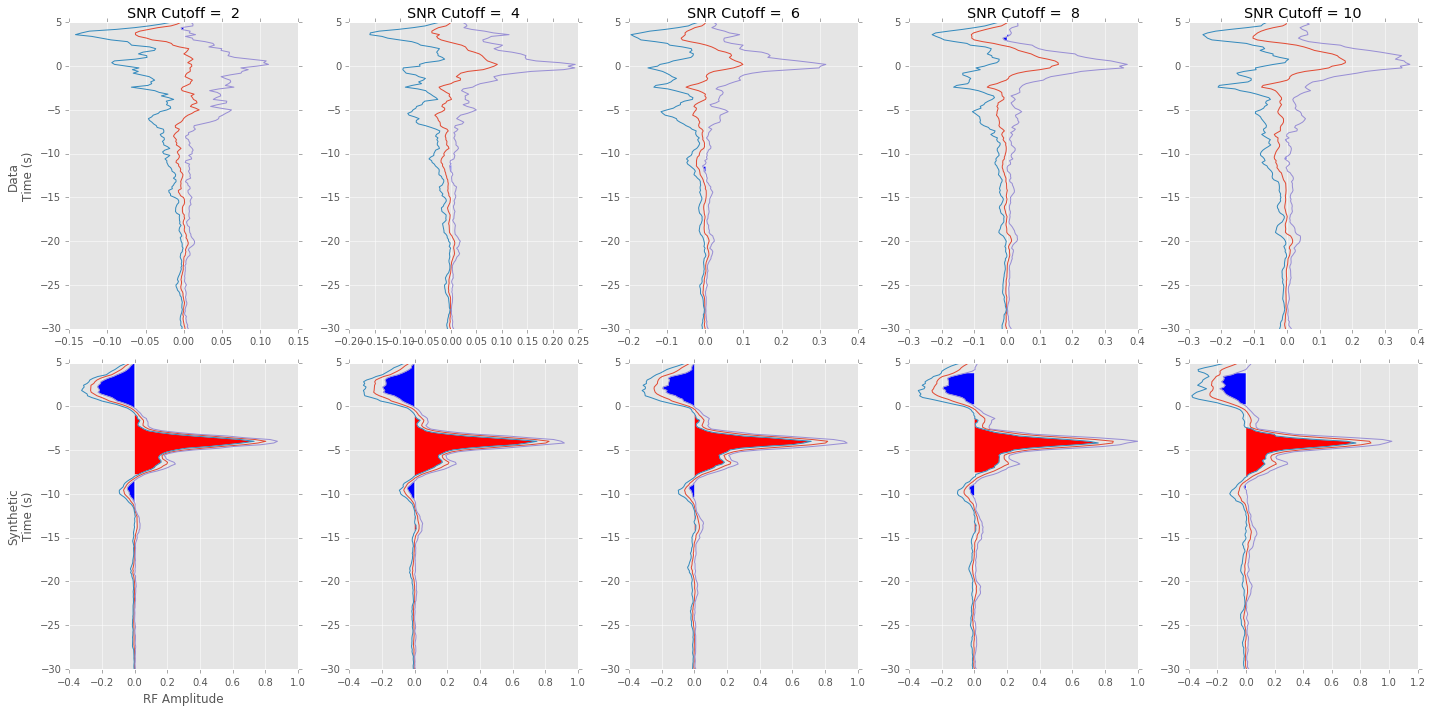

In [45]:
from numpy import nanmean, nanmedian, nanstd
from numpy.random import choice

#times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

#nrfs = len(cat2)
#nrfs = 329

minsnrs = arange(2, 12, 2)

#rbin_sn = rbin_s.copy() + randn(rbin_s.shape[0],rbin_s.shape[1],rbin_s.shape[2])*0.05

for iplt, minsnr in enumerate(minsnrs):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        snr_sample = arange(len(cat2))[mbin2[0,:]>minsnr]
        
        nrfs = len(snr_sample)
        
        rbin1=rbin0[0,snr_sample,:]
        
        nboot = 500

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        for iboot in range(nboot):
            random_sample = choice(range(nrfs), nrfs, replace=True)
            bbin[iboot,:] = nanmedian(rbin1[random_sample,:len(RF)],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(minsnrs),iplt+1)
        else:
            plt.subplot(2,len(minsnrs),iplt+1+len(minsnrs))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        if irow == 0:
            plt.title('SNR Cutoff = %2d' % (minsnr) )

plt.subplot(2,len(minsnrs),1)
plt.ylabel('Data\nTime (s)')
plt.subplot(2,len(minsnrs),1+len(minsnrs))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')

#plt.ylabel('Time (s)')
#plt.xlabel('RF Amplitude')
    
plt.tight_layout()
plt.savefig('NRIL_SNR.eps')

(array([ 556.,   56.,   26.,   16.,    6.,    2.,    2.,    4.,    6.,   18.]),
 array([  15.  ,   78.82,  142.64,  206.46,  270.28,  334.1 ,  397.92,
         461.74,  525.56,  589.38,  653.2 ]),
 <a list of 10 Patch objects>)

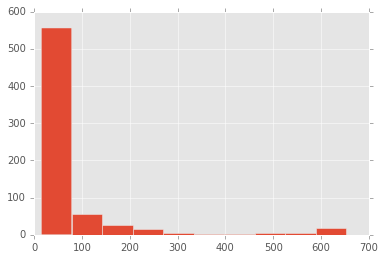

In [27]:
tmp=[]
for ievt, evt in enumerate(cat2):
    elat=evt.preferred_origin().latitude
    elon=evt.preferred_origin().longitude
    edep=evt.preferred_origin().depth/1000.0
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg = delm/1000./111.11
    tmp.append(edep)
    
plt.hist(tmp)

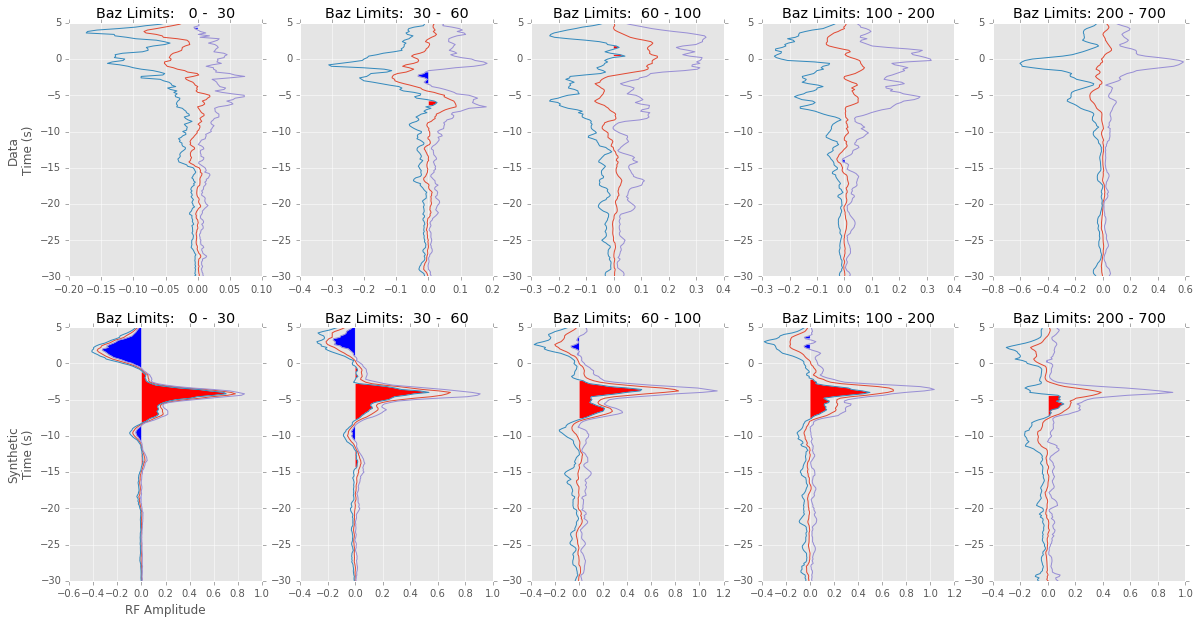

In [29]:
from numpy import nanmean, nanmedian, nanstd, array, shape
from numpy.random import choice

#times, RF = IDRF(P,D,dt)


depthranges = [(0,30),(30,60),(60,100),(100,200),(200,700)]

iplt = 4

for iplt, depthrange in enumerate(depthranges):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        dmin, dmax = depthrange[0], depthrange[1]

        slic = array(array(tmp) > dmin) & array(array(tmp) < dmax)

        #print(dmin, dmax, len(slic))

        nboot = 100

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        rbin2 = rbin0[0,slic,:len(RF)]
        nrf,_ = shape(rbin2)

        for iboot in range(nboot):

            random_sample = choice(range(nrf), nrf, replace=True)

            #print(nrf, len(random_sample))

            bbin[iboot,:] = nanmedian(rbin2[random_sample,:],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(depthranges),iplt+1)
        else:
            plt.subplot(2,len(depthranges),iplt+1+len(depthranges))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        #plt.xlim(-0.3,0.3)
        plt.title('Baz Limits: %3d - %3d' % (dmin, dmax))

plt.subplot(2,len(depthranges),1)
plt.ylabel('Data\nTime (s)')
        
plt.subplot(2,len(depthranges),1+len(depthranges))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')
    
#plt.tight_layout()
plt.savefig('NRIL_baz_limted.eps')

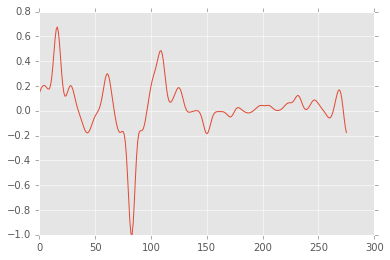

In [43]:
plt.plot(rbin[0,250,:])